<a href="https://colab.research.google.com/github/Stephaaniee/ProjectWork/blob/main/Data_Fast_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai


In [ ]:
!pip install fastbook

In [ ]:
from fastai.vision.all import *
from fastai.data.core import DataLoader
import random
import re
import os
import shutil
import PIL
import torch
import numpy as np
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.data.core import DataLoaders
from fastbook import *
import pathlib
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = ('/content/drive/MyDrive/sugar_beets')

In [ ]:
dataset_url = "https://hshl.sciebo.de/s/29IxZnIdXBbFPZ4"
data_dir = tf.keras.utils.get_file(origin= dataset_url,
                                   fname= 'sugar_beets',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

10333/10333 [==============================] - 0s 0us/step


In [ ]:
files = get_image_files(path) #looks for image in file recursively
files[0]

Path('/content/drive/MyDrive/sugar_beets/sick/dji-56-image-1363.jpg')

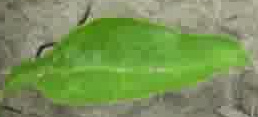

In [ ]:
#open the first image
img = PIL.Image.open(files[0])
img

In [ ]:
#split data set

def split_data(source_folder, train_folder, test_folder, test_size):
    for root, dirs, files in os.walk(source_folder):
        if files:
            # paths
            rel_path = os.path.relpath(root, source_folder)
            train_subfolder = os.path.join(train_folder, rel_path)
            test_subfolder = os.path.join(test_folder, rel_path)

            # Create these subfolders if they don't already exist
            os.makedirs(train_subfolder, exist_ok=True)
            os.makedirs(test_subfolder, exist_ok=True)

            # Filter out non-image files if necessary
            images = [f for f in files if os.path.isfile(os.path.join(root, f))]

            # Determine the number of images to select for the test set
            num_test_images = int(len(images) * test_size)

            # Randomly select images for the test set
            test_images = random.sample(images, num_test_images)

            # The remaining images will be used for the training set
            train_images = [img for img in images if img not in test_images]

            # Copy the training images to the train subfolder
            for img in train_images:
                shutil.copy(os.path.join(root, img), os.path.join(train_subfolder, img))

            # Copy the testing images to the test subfolder
            for img in test_images:
                shutil.copy(os.path.join(root, img), os.path.join(test_subfolder, img))

            print(f"Processed folder: {rel_path}")
            print(f"Training images: {len(train_images)}")
            print(f"Testing images: {len(test_images)}")

# Paths to the corresponding folders
source_folder = path # Where are the source files?
train_folder = "/content/drive/MyDrive/train_folder" # Where to save the train files?
test_folder = "/content/drive/MyDrive/test_folder" # Where to save the test files?

# Percentage of images to be moved to the test folder
test_size = 0.2

split_data(source_folder, train_folder, test_folder, test_size=test_size)

Processed folder: sick
Training images: 1620
Testing images: 405


KeyboardInterrupt: 

In [ ]:
# # build fast data set loaders
# np.random.seed(42)
# data = ImageDataLoaders.from_folder(path, ds_tfms=tfms, size=24)

In [ ]:
#REFERENCE: https://medium.com/@qasimr.1097/journeying-through-fastai-building-an-image-classifier-using-kaggle-data-9bc5762fe676

# defining the path to our training images
train_folder = "/content/drive/MyDrive/train_folder"
# creating a pipeline for data assembly using fast.ai DataBlock api
asl = DataBlock(blocks=(ImageBlock, CategoryBlock), #these are not functions are classes
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42), #split_pct = 0.2 instead of valid_pct=0.2
                get_y = parent_label,
                item_tfms = RandomResizedCrop(200, min_scale=0.5),
                batch_tfms = aug_transforms(mult=2)
               )
# loading in the data with a batch size of 32, using fast.ai dataloaders
dls = asl.dataloaders(train_folder, bs = 32)#supposed to use the entire image data set

<ipython-input-12-1cfcb35600b7>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


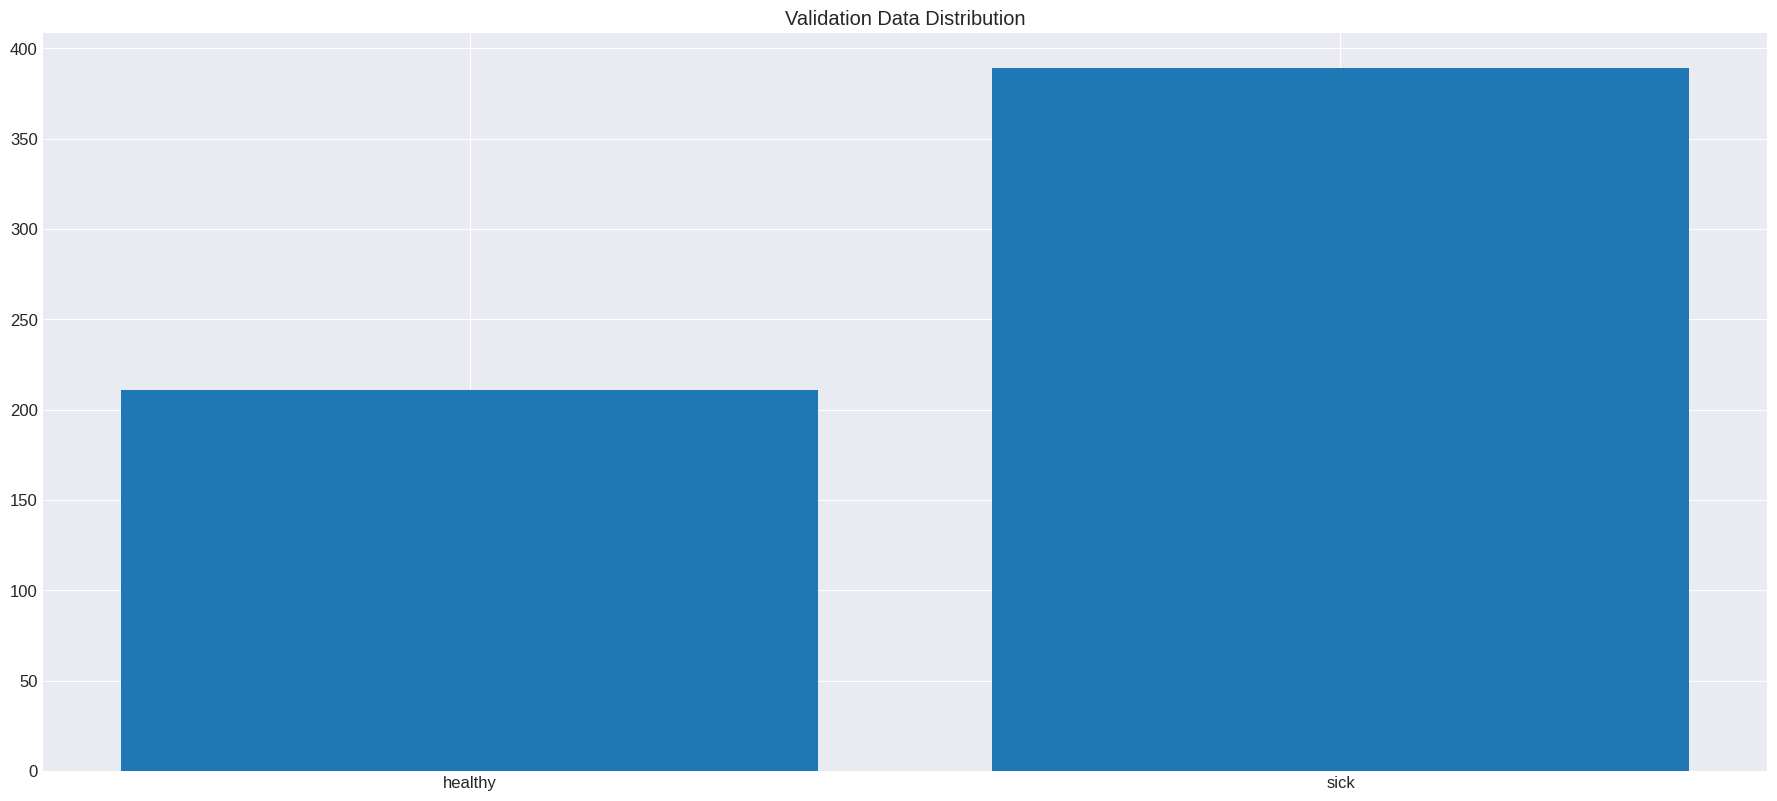

In [ ]:
#view distribution of dataset
from collections import Counter

plt.style.use('seaborn-darkgrid')

def category_count(class_items, title):

  list_of_classes = [path.parts[-2] for path in class_items]
  d = dict(sorted(Counter(list_of_classes).items()))

  fig, ax = plt.subplots(figsize=(18,8))
  fig.tight_layout()

  plt.title(title)
  ax.bar(d.keys(), d.values())

category_count(dls.valid_ds.items, 'Validation Data Distribution')

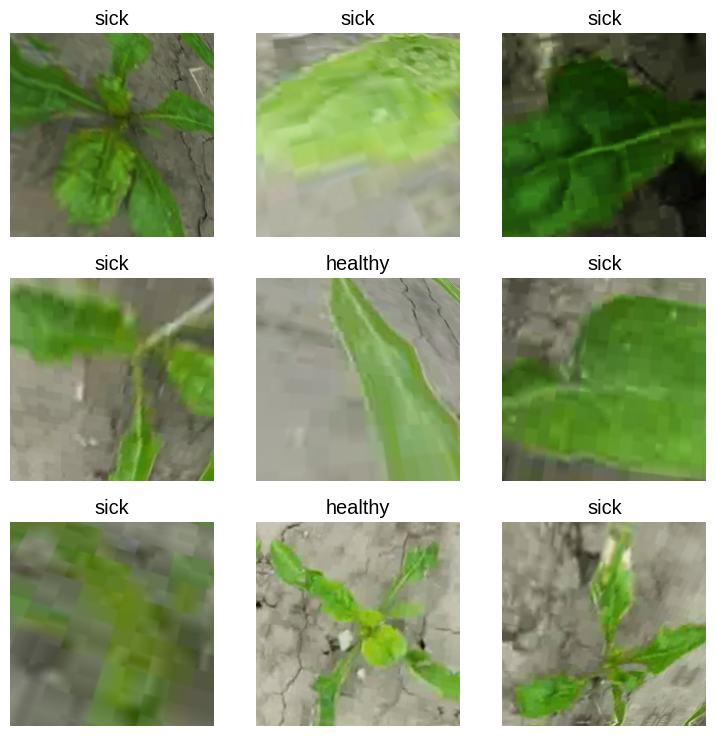

In [ ]:
#view sample of training images
dls.show_batch(max_n=9)

In [ ]:
#Model Training
#cnn_learner` has been renamed to `vision_learner
#fit_one_cycle() method trains the model on our data set for 4 epochs

# learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16()
# learn.fit_one_cycle(4)
learn = vision_learner(dls, resnet34, metrics=accuracy).to_fp16()
#try this - learn = vision_learner(dls, resnet34, metrics=error_rate)
# learn.fit_one_cycle(20)
#too low achieved ~50% accuracy

epoch,train_loss,valid_loss,accuracy,time


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 41, in fetch
    data = next(self.dataset_iter)
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/load.py", line 138, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/usr/local/lib/python3.10/dist-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/load.py", line 168, in do_item
    try: return self.after_item(self.create_item(s))
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/load.py", line 175, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/core.py", line 447, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/core.py", line 447, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/core.py", line 406, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/usr/local/lib/python3.10/dist-packages/fastai/data/core.py", line 366, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/fastai/vision/core.py", line 125, in create
    return cls(load_image(fn, **merge(cls._open_args, kwargs)))
  File "/usr/local/lib/python3.10/dist-packages/fastai/vision/core.py", line 98, in load_image
    im = Image.open(fn)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3283, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file '/content/drive/MyDrive/train_folder/healthy/dji-54-image-1654.jpg'


In [ ]:
# view this difference by viewing a sample of the validation images only.
dls.valid.show_batch(max_n=8, nrows=2)

In [ ]:
#  export its meta data as a .pkl file, and then load it later for inference
#to export the model
learn.export('/content/drive/MyDrive/savedTrainedImages/asl_model.pkl')

# to load the model for inference
learner_inf = load_learner('/content/drive/MyDrive/savedTrainedImages/asl_model.pkl')

In [ ]:
#Evaluate our trainig with the test dataset

test_dl = dls.test_dl(get_image_files_sorted("/content/drive/MyDrive/test_folder"))

# getting the predictions of our model
preds, _ = learner_inf.get_preds(dl=test_dl)

In [ ]:
import tensorflow as tf

print(tf.shape(preds))

In [ ]:
# first, we figure out the index that has the max probability in each row
# this is the index of the class our model believes the test image belongs to
y = torch.argmax(preds, dim=1)

# now, we make use of the o2i methods to find the class associated with each index
# since o2i is actually a mapping from class to index value, we modify the code to compute the reverse mapping
cls_preds = list(map(lambda x: list(dls.vocab.o2i.keys())[list(dls.vocab.o2i.values()).index(x)], y))

# print our predictions of each test image
print(cls_preds)

In [ ]:
# compare predictions with the actual test labels

# load in the paths of all test images
imgs = get_image_files_sorted('/content/drive/MyDrive/sugar_beets')
# extract the labels of each image
true_labels = [imgs[i].parts[-1].split('_')[0] for i in range(len(imgs))]

# compare model predictions with actual output
comp = [x == y for x,y in zip(cls_preds, true_labels)]

# if we sum up our comparison list, we total comes out as 28
# this means that all 28 of our predictions was correct
sum(comp)